Decided to use PyTorch. Keras was giving me quite a headache with it's abstractions.

In [1]:
# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils, datasets

# Misc. Imports
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from skimage import io, transform

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 1070 Ti'

In [3]:
data = pd.read_csv("./lesion-csv.csv")
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# All we care about at this point is the id and class
train_df = train_df.drop(["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)
test_df = test_df.drop(["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

partition = {
    "train": train_df.imageId.values,
    "validation": test_df.imageId.values,
}

In [52]:
class TeethLesionDataset(Dataset):
    """Teeth Lesion dataset."""
    
    def __init__(self, train_frame, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with image ids and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.lesions_train_frame = train_frame
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.lesions_train_frame)
    
    def __getitem__(self, idx):
        image_id = self.lesions_train_frame.iloc[idx].imageId
        image = io.imread(self.root_dir + image_id + '.jpg')
        image = transform.resize(image, (224,224))
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        
        label = self.lesions_train_frame.iloc[idx].lesion
        label = torch.from_numpy(np.array(label))
        
        # if self.transform:
        #     image = self.transform(image)
    
        return image, label

In [53]:
lesion_dataset = TeethLesionDataset(train_df, './lesion_images/all_images_processed/')
validation_set = TeethLesionDataset(test_df, './lesion_images/all_images_processed/')

0 torch.Size([3, 224, 224])
0 torch.Size([])
0 tensor(1., dtype=torch.float64)


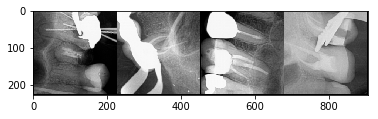

1 torch.Size([3, 224, 224])
1 torch.Size([])
1 tensor(0., dtype=torch.float64)


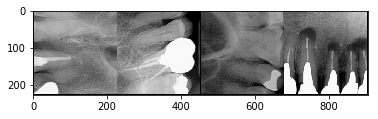

2 torch.Size([3, 224, 224])
2 torch.Size([])
2 tensor(0., dtype=torch.float64)


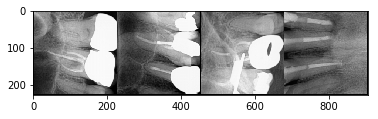

3 torch.Size([3, 224, 224])
3 torch.Size([])
3 tensor(0., dtype=torch.float64)


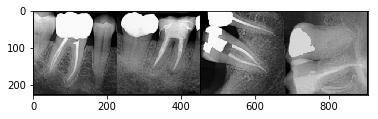

In [54]:
dataloader = DataLoader(lesion_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    images, labels = sample_batched
    print(i_batch, images[0].shape)
    print(i_batch, labels[0].shape)
    print(i_batch, labels[0])
    
    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    plt.show()

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [55]:
import torchvision.models as models

class CNN_Model(nn.Module):
    
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()
        
        self.dataloader = dataloader
        
        self.densenet = models.densenet161(pretrained=True)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.out_act = nn.Sigmoid()
        
    def forward(self, x):
        output = self.densenet(x)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x1 = x.view(-1, 16 * 53 * 53)
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = self.out_act(self.fc3(x1))
        
        return x1

    
class CNN:
    
    def __init__(self, dataloader, model):
        self.dataloader = dataloader
        self.criterion = nn.BCELoss()
        self.optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        self.model = model
        self.running_loss = 0.0
        self.num_epochs = 2
        
        self.register_hooks("conv2")
        
    def register_hooks(self, target_layer):
        print("Registering Hooks")
        
        def forward_hook(module, input_, output_):
            self._last_activation = output_

        def backward_hook(module, grad_in, grad_out):
            self._last_grad = grad_out[0]

        for layer_name, layer in self.model.named_modules():
            if layer_name == target_layer:
                layer.register_forward_hook(forward_hook)
                layer.register_backward_hook(backward_hook)
                print("Hooks Regsitered for layer: ", target_layer)
                break
    
    def train(self):
        print('Starting Training')
        for epoch in range(self.num_epochs):  # loop over the dataset multiple times
            for batch_idx, data in enumerate(self.dataloader, 0):
                # get the inputs
                inputs, labels = data

                # zero the parameter gradients
                self.optimizer.zero_grad()

                classification, class_loss, attention_map = self.forward(inputs, labels)
                
                class_loss.backward()
                self.optimizer.step()

                # print statistics 
                if batch_idx % 20 == 0:    # print every 20 mini-batches
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(dataloader.dataset),
                        100. * batch_idx / len(dataloader), class_loss.item()))

        print('Finished Training')
    
    def forward(self, inputs, labels):
        # forward + backward + optimize
        classification = self.model(inputs)
        
        float_labels = labels.float()
        
        # Need to do this so that self._last_grad will be set.
        grad_target = (classification * float_labels).sum()
        grad_target.backward(gradient=float_labels * classification, retain_graph=True)
        
        self.model.zero_grad()

        # attention map stuff?
        # Eq 1
        class_weights = F.avg_pool2d(
            self._last_grad, 
            (self._last_grad.shape[-2], self._last_grad.shape[-1]),
            1)
        class_weights_new_shape = (
            class_weights.shape[0] * class_weights.shape[1], 
            class_weights.shape[2], class_weights.shape[3])
        class_weights_reshaped = class_weights.view(class_weights_new_shape).unsqueeze(0)
        

        # Eq 2
        weights = self._last_activation
        weights_new_shape = (weights.shape[0] * weights.shape[1], weights.shape[2], weights.shape[3])
        weights_reshaped = weights.view(weights_new_shape).unsqueeze(0)

        grad_cam = F.relu(F.conv2d(weights_reshaped, class_weights_reshaped))
        attention_map = F.upsample(grad_cam, size=inputs.size()[2:], mode='bilinear')
        
        class_loss = self.criterion(classification, float_labels)
        
        return classification, class_loss, attention_map
    
    def predict(self, validation_set):
        testloader = DataLoader(validation_set, batch_size=4,
                        shuffle=True, num_workers=4)

        correct1 = 0
#         correct2 = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                out1 = self.model(images)
#                 out1, out2 = net(images)
                _, predicted1 = torch.max(out1.data, 1)
#                 _, predicted2 = torch.max(out2.data, 1)
                total += labels.size(0)
                correct1 += (predicted1 == labels).sum().item()
#                 correct2 += (predicted2 == labels).sum().item()

        print('Accuracy of the network on the test images: %d %%' % (100 * correct1 / total))
#         print('Accuracy of the network on the test images: %d %%' % (100 * correct2 / total))

In [56]:
cnn_model = CNN_Model(1)
cnn = CNN(dataloader, cnn_model)

Registering Hooks
Hooks Regsitered for layer:  conv2


In [57]:
cnn.train()

Starting Training


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight'

In [ ]:
cnn.predict(validation_set)

In [ ]:
# Attention map output test

for i_batch, sample_batched in enumerate(dataloader):
    images, labels = sample_batched
    
    classification, class_loss, attention_map = cnn.forward(images, labels)
    break
    

In [ ]:
flat_heatmap = attention_map[0].detach().numpy().flatten()
print(flat_heatmap.shape)
np.max(flat_heatmap)
# np.true_divide(flat_heatmap, np.max(flat_heatmap))
# heatmap = attention_map[0].permute(1, 2, 0).detach().numpy()
# flat_heatmap = heatmap.flatten()

# heatmap = np.true_divide(heatmap, np.max(heatmap))
# heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
# print(heatmap.shape)
# plt.imshow(heatmap)


I think what I need to do, is to create an initial classification model to load into the Attention Map class. From there I can define a new forward pass that will use the classification output of that model.

I can also define the layer names in that model and use the register hooks function to apply a backward hook to the last conv layer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
for idx, m in net.named_modules():
    print("index: ", idx)
    print("layer: ", m)